# Import Libraries and fetch data

In [1]:
# import pandas for dataframe manipulation and other utilities
import pandas as pd

# import numpy for array-wise operations and other math utilities
import numpy as np

# import pyplot as foundational visualization library
import matplotlib.pyplot as plt

# import PCA for principal component analysis
from sklearn.decomposition import PCA

# used to standardize the data
from sklearn.preprocessing import scale

# import pca library for comprehensive PCA analysis and prep tools
from pca import pca as pca_funct

# import seaborn for additional visualization functions
import seaborn as sns

# filter out warnings to clean up output
import warnings
warnings.filterwarnings('ignore')

# set random seed state to make results repeatable
rand_state = 42

# import data
df = pd.read_csv('data/medical_clean.csv')

# import manually created data definitons as lookup table for differentiating qualitative/quantitative columns for processing
df_var_definitions = pd.read_csv('data/var_definitions.csv', encoding = 'unicode_escape', engine ='python')

# Remove duplicates and check for nulls

In [2]:
# check for null/nan values
# and print results
# from source: https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
print(f'Total rows in whole dataset: {df.shape[0]}')
print(f'{"="*80}')
print(f'number of nulls found: {df.isnull().sum().sum()}')

# check that there are 10,000 rows if you run drop na
df = df.dropna()
print(f'number of rows after dropping rows with na values: {df.shape[0]}')
print(f'change detected after duplicates dropped?: {df.drop_duplicates().shape[0] != df.shape[0]}')

# check for duplicates
print(f'number of rows with duplicate values: {df.duplicated().sum()}')

Total rows in whole dataset: 10000
number of nulls found: 0
number of rows after dropping rows with na values: 10000
change detected after duplicates dropped?: False
number of rows with duplicate values: 0


# Use reference sheet to pull continuous variables

In [3]:
# create copy of dataframe for further manipulation
df_init = df.copy(deep=True)

# strip any whitespace to avoid frustrating naming mismatches
df_init = df_init.rename(columns=lambda x: x.strip())

# fetch column mapping from var definition file
new_col_df = df_var_definitions.copy(deep=True)

var_dict = new_col_df.set_index('Variable Name')['Standardized Name'].to_dict()

# rename columns using the mapping defined above
df_init.rename(columns = var_dict, inplace=True)

# create two lists of columns: one of all continuous variables and everything else
continuous_columns = []
unmapped_columns = []

map_count = 0

# test and add columns to appropriate list based on stripped column name from var list
for column in df_init.columns:
    curr_type = df_var_definitions.loc[df_var_definitions['Standardized Name'].str.strip() == column,'Sub Type']

    try:
        if curr_type.size > 0:
            if curr_type.values[0] == 'Continuous':
                continuous_columns.append(column)
                
        else:
            unmapped_columns.append(column)
            
    except:
        print('something went wrong')
        
# count mapped columns
map_count = len(continuous_columns)

# compare total column count vs. mapped and display warning if mismatched
print(f'{"--"*20}\n {map_count} of {len(df_init.columns)} columns mapped successfully \n{"--"*20}')

if len(unmapped_columns) > 0:
    print(f'WARNING: Unable to map some columns that were marked continuous: {unmapped_columns} \n{"=="*20}')

----------------------------------------
 8 of 50 columns mapped successfully 
----------------------------------------


In [4]:
# display type and number of continuous colunns found
df_init[continuous_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 10000 non-null  float64
 1   lng                 10000 non-null  float64
 2   age                 10000 non-null  int64  
 3   income              10000 non-null  float64
 4   vit_d_levels        10000 non-null  float64
 5   initial_days        10000 non-null  float64
 6   total_charge        10000 non-null  float64
 7   additional_charges  10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


# Explore Continuous variables correlation

*src = https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-i-selecting-for-feature-information?ex=9*

<Axes: >

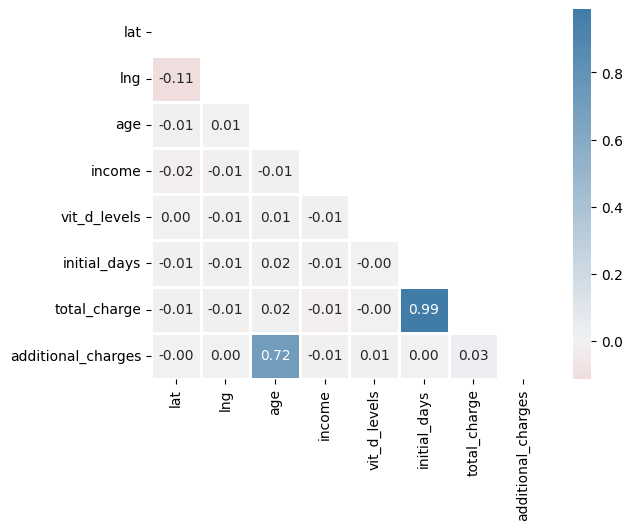

In [5]:
corr = df_init[continuous_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(h_neg=10,h_pos=240, as_cmap=True)

sns.heatmap(corr, mask=mask, center=0, cmap=cmap, linewidths=1, annot=True, fmt=".2f")

# Create copy of initial dataframe with only continuous variables

In [6]:
# create dataframe copy using only continuous columns
df_pca = df_init[continuous_columns].copy(deep=True)


# Create elbow plot using more manual process

*src = https://westerngovernorsuniversity-my.sharepoint.com/personal/keiona_middleton_wgu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fkeiona%5Fmiddleton%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD206%2FUnderstanding%20PCA%2Epdf&parent=%2Fpersonal%2Fkeiona%5Fmiddleton%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD206&ga=1*

In [7]:
# create normalized version of dataframe
df_pca_normalized = (df_pca-df_pca.mean())/df_pca.std()

# perform PCA 
pca = PCA(n_components=df_pca.shape[1])

# fit model
pca.fit(df_pca_normalized)

# load results into dataframe
pca_results = pd.DataFrame(pca.transform(df_pca_normalized))

# Create loadings 
manual_loadings = pd.DataFrame(pca.components_.T, columns=df_pca_normalized.columns,index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])

# create covariance matrix
cov_matrix = np.dot(df_pca_normalized.T, df_pca_normalized)/pca_results.shape[0]

# transpose loadings dataframe for easier comparison with more automatic pca output
manual_loadings

,lat,lng,age,income,vit_d_levels,initial_days,total_charge,additional_charges
PC1,-0.013079,-0.008216,0.707443,0.010501,-0.093762,-0.700262,0.003858,0.001483
PC2,-0.010528,0.010934,-0.698601,-0.137959,-0.114966,-0.692410,-0.006681,-0.000357
PC3,0.085809,0.701541,0.002471,0.017929,-0.000156,-0.003099,0.706716,0.026313
PC4,-0.020516,-0.018690,-0.087846,0.725834,0.661202,-0.165777,0.002308,0.001312
PC5,-0.001636,0.019146,0.059987,-0.673096,0.735289,-0.048152,-0.001932,-0.001552
PC6,0.701050,-0.091424,-0.000290,0.007525,0.008485,-0.014659,0.031677,-0.706274
PC7,0.702184,-0.080868,-0.001272,0.005167,0.009042,-0.013262,-0.031469,0.706486
PC8,0.086013,0.701455,0.012542,0.023631,0.000546,-0.000853,-0.706038,-0.036819


# save cleaned and scaled dataset

In [8]:
# export copy of cleaned and scaled dataset
df_pca_normalized.to_csv('cleaned_scaled_medical_continuous.csv')

*src = https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca*

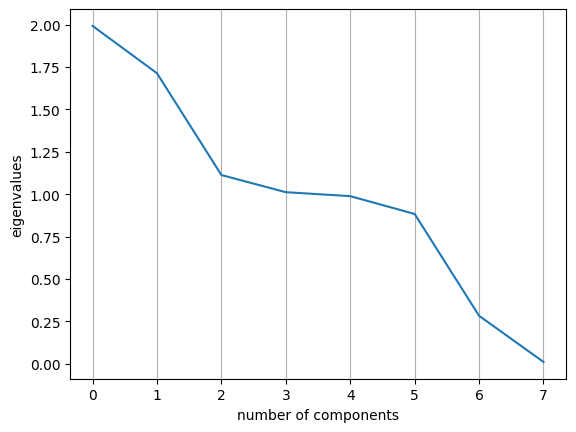

In [9]:
# get eigen values
eigenvalues=[np.dot(eigenvector.T,np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]

# load eigen values into a scree plot
# scree plot is difficult to determine based on the typical elbow appearance

plt.plot(eigenvalues)
plt.xlabel('number of components')
plt.ylabel('eigenvalues')
plt.xticks(range(0,8))
plt.grid(axis='x')

plt.show()

# Use Kaiser Criteria as elbow method is not clear enough

In [10]:
# create numpy array and filter by values greater than or equal to one
# To choose Principal Components using the Kaiser Criteria
eigen_np_array = np.array(eigenvalues)
eigen_np_array[eigen_np_array >= 1]

array([1.9922474 , 1.71333875, 1.11332099, 1.0121942 ])

# Train PCA model on normalized data

In [11]:
model = pca_funct(n_components=4, normalize=True)
outcomes = model.fit_transform(df_pca)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


# Explore variance for each Principal Component

In [12]:
explained_variance_df = pd.DataFrame([pca.explained_variance_,pca.explained_variance_ratio_], columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'],index=['Variance','Variance Ratio'])
explained_variance_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Variance,1.992447,1.713510,1.113432,1.012295,0.98896,0.884006,0.283633,0.011717
Variance Ratio,0.249056,0.214189,0.139179,0.126537,0.12362,0.110501,0.035454,0.001465


In [13]:
# create new dataframe for explained variance with only variables
# that meet the Kaiser Criteria
explained_variance_df = pd.DataFrame([pca.explained_variance_[0:4],pca.explained_variance_ratio_[0:4]], columns=['PC1','PC2','PC3','PC4'],index=['Variance','Variance Ratio'])
explained_variance_df

,PC1,PC2,PC3,PC4
Variance,1.992447,1.713510,1.113432,1.012295
Variance Ratio,0.249056,0.214189,0.139179,0.126537


In [14]:
# manually add up the first 4 PC's to get a value to
# verify that table values agree with scree plot
explained_variance_df.transpose()['Variance Ratio'][0:4].sum()

0.7289605637513796

# Scree plot and % of explained variance

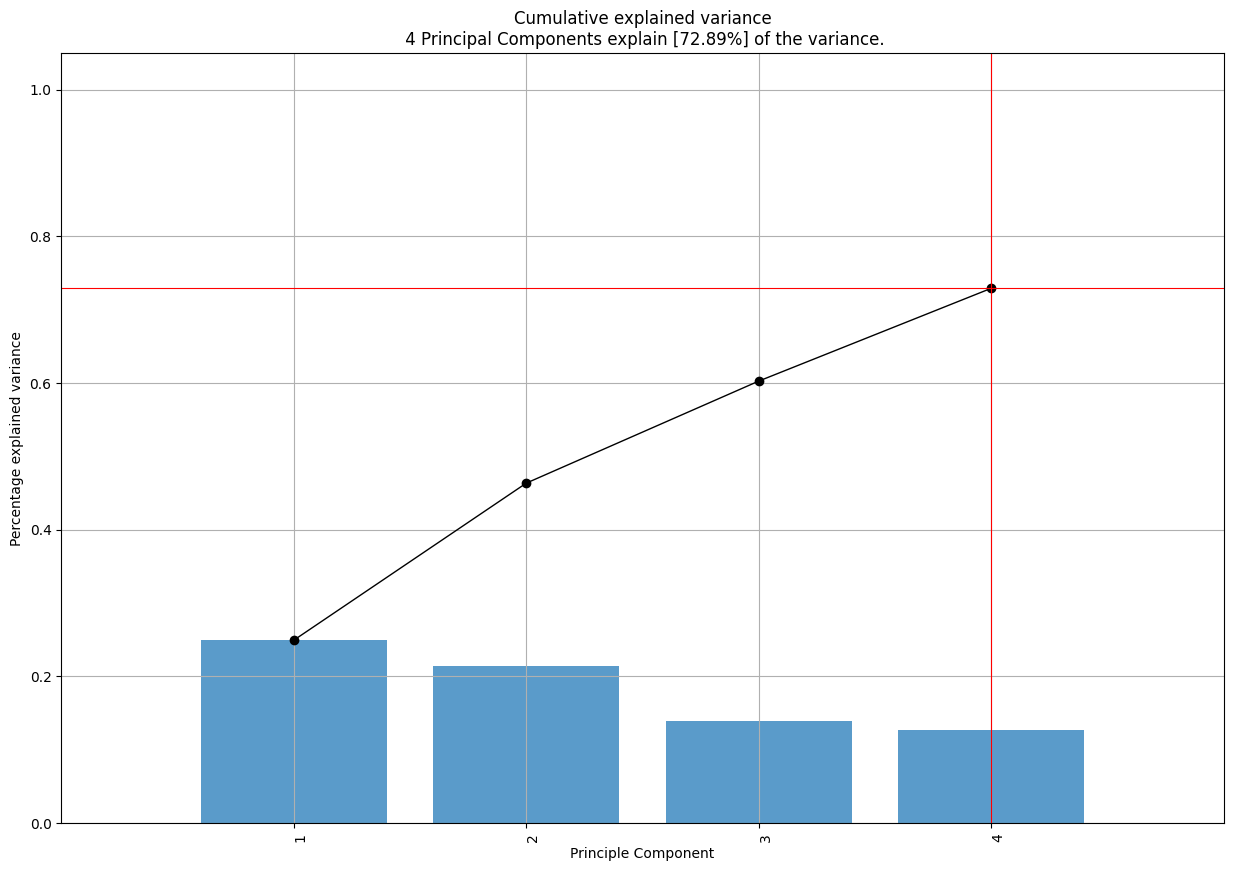

In [15]:
model.plot()
plt.show()